In [117]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_opening


Assignment 1 – Gaussian Mixture Model bằng NumPy 

🔹 1.1: "Use Numpy only to implement GMM"

In [118]:
# ======= Gaussian function =======
def gaussian(X, mean, cov):
    n = X.shape[1]
    cov_inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2*np.pi), n/2) * np.sqrt(det))
    X_centered = X - mean
    result = np.exp(-0.5 * np.sum(X_centered @ cov_inv * X_centered, axis=1))
    return norm_const * result


1.2: "Train GMM with EM method"

In [119]:
# ======= GMM EM Algorithm =======
def gmm_em(X, k=2, max_iter=100, tol=1e-4):
    n, d = X.shape
    np.random.seed(0)
    indices = np.random.choice(n, k, replace=False)
    means = X[indices]
    covariances = [np.cov(X.T) + 1e-6 * np.eye(d) for _ in range(k)]
    weights = np.ones(k) / k

    log_likelihood_old = 0

    for _ in range(max_iter):
        probs = np.zeros((n, k))
        for i in range(k):
            probs[:, i] = weights[i] * gaussian(X, means[i], covariances[i])
        probs_sum = np.sum(probs, axis=1, keepdims=True)
        probs /= probs_sum

        Nk = np.sum(probs, axis=0)
        for i in range(k):
            means[i] = np.sum(probs[:, i][:, None] * X, axis=0) / Nk[i]
            X_centered = X - means[i]
            covariances[i] = (probs[:, i][:, None] * X_centered).T @ X_centered / Nk[i]
            covariances[i] += 1e-6 * np.eye(d)
        weights = Nk / n

        log_likelihood = np.sum(np.log(np.sum(probs * weights, axis=1)))
        if abs(log_likelihood - log_likelihood_old) < tol:
            break
        log_likelihood_old = log_likelihood

    return means, covariances, weights

In [120]:
# ======= Dự đoán cluster =======
def predict(X, means, covs, weights):
    n = X.shape[0]
    k = len(means)
    probs = np.zeros((n, k))
    for i in range(k):
        probs[:, i] = weights[i] * gaussian(X, means[i], covs[i])
    return np.argmax(probs, axis=1)


In [121]:
# ======= Chuẩn hóa và resize ảnh =======
def preprocess_image(img, max_dim=512):
    h, w = img.shape[:2]
    scale = max_dim / max(h, w)
    if scale < 1.0:
        img = np.array(Image.fromarray(img).resize((int(w * scale), int(h * scale))))
    return img

Assignment 2 – Lọc nền từ ảnh bằng GMM (2 điểm)

In [ ]:
# ======= Hàm chính xử lý ảnh =======
def extract_foreground(image_path):
    img = np.array(Image.open(image_path).convert('RGB'))
    img = preprocess_image(img)
    h, w, _ = img.shape
    X = img.reshape(-1, 3).astype(np.float64) / 255.0
    means, covs, weights = gmm_em(X, k=2)
    labels = predict(X, means, covs, weights)
    labels_img = labels.reshape(h, w)
    fg_label = 0 if np.sum(labels_img == 0) < np.sum(labels_img == 1) else 1
    mask = (labels_img == fg_label).astype(np.uint8)

    mask_clean = binary_opening(mask, structure=np.ones((5, 5))).astype(np.uint8)
    labeled, num = label(mask_clean)
    sizes = [(labeled == i).sum() for i in range(1, num+1)]
    if sizes:
        max_label = np.argmax(sizes) + 1
        final_mask = (labeled == max_label).astype(np.uint8)
    else:
        final_mask = mask_clean
    final_mask = final_mask[:, :, None]
    foreground = img * final_mask  
    return img, foreground


2.1: "Use GMM to filter out background"

In [ ]:
# ======= Hàm xử lý nhiều ảnh =======
def extract_foregrounds(image_paths):
    results = []
    for path in image_paths:
        try:
            original, foreground = extract_foreground(path)
            results.append((path, original, foreground))
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh '{path}': {e}")
    return results

2.2: "Display the foreground / post-process the mask"

In [ ]:
# ======= Hiển thị kết quả =======
def show_results(results):
    plt.figure(figsize=(10, 10))
    for i, (path, orig, fg) in enumerate(results):
        plt.subplot(len(results), 2, 2*i + 1)
        plt.imshow(orig)
        plt.title("Original")
        plt.axis('off')
        plt.subplot(len(results), 2, 2*i + 2)
        plt.imshow(fg)
        plt.title("Foreground (GMM)")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



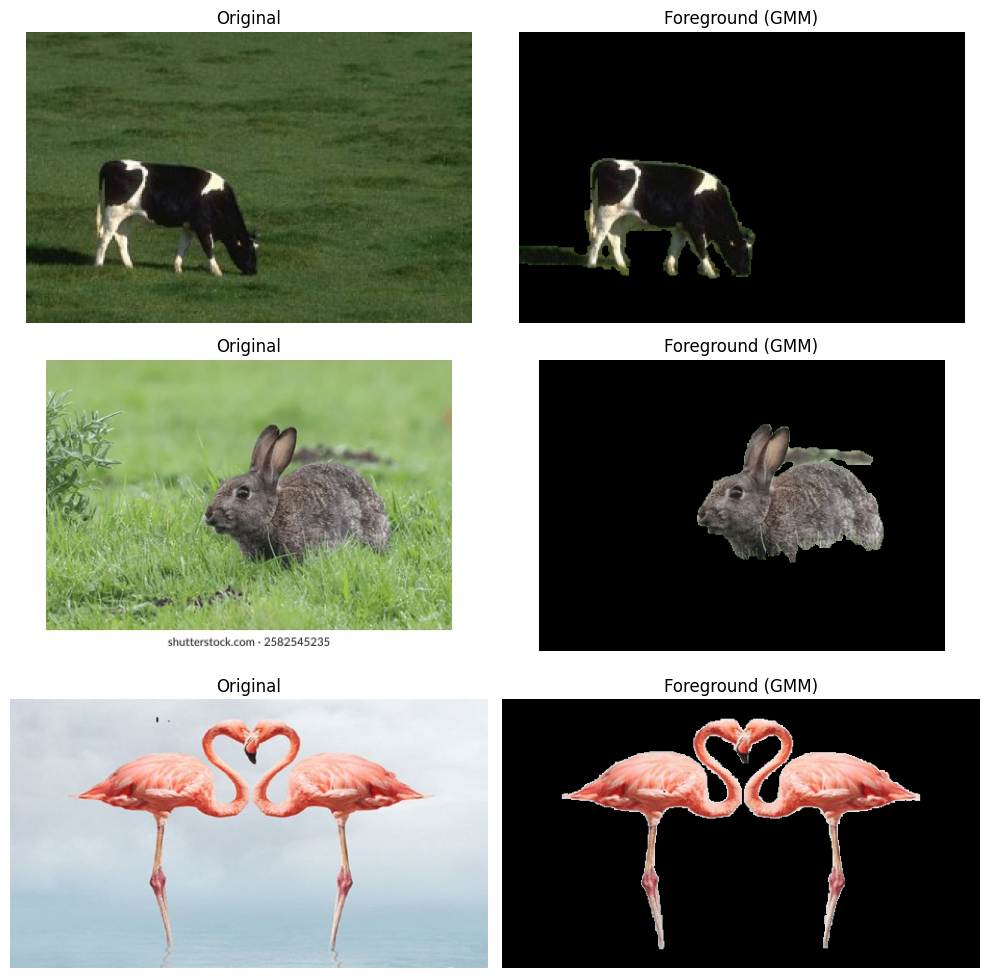

In [125]:
# ======= Ví dụ dùng thử =======
if __name__ == "__main__":
    image_paths = [
        "C:/Users/ADMIN/Downloads/cow.jpg",
        "C:/Users/ADMIN/Downloads/rabbit1.jpg",
        "C:/Users/ADMIN/Downloads/hha.jpg"
    ]
    results = extract_foregrounds(image_paths)
    show_results(results)
